<a href="https://colab.research.google.com/github/imyoungchae/Tensorflow_study/blob/main/tensorflow7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN을 활용한 텍스트 분류(Text Classification)

# Import

In [2]:
import json
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

Data Set Download

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x7f4984686510>)

Json File Load

In [4]:
with open('sarcasm.json') as f:
    datas = json.load(f)

In [5]:
datas[:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

# 전처리: 데이터셋 구성(sentences,labels)

- X(Feature):sentences
- Y(Label):label

빈 list 생성

In [6]:
sentences = []
labels = []

In [7]:
for data in datas:
    sentences.append(data['headline'])
    labels.append(data['is_sarcastic'])

문장 5개 출력

In [8]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [9]:
labels[:5]

[0, 0, 1, 1, 0]

# Train/Validation Set 분리

In [10]:
training_size = 20000

In [11]:
train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

In [12]:
validation_sentences = sentences[training_size:]
validation_labels = labels[training_size:]

# 전처리1 Tokenizer 정의

- num_words: 단어 max 사이즈를 지정/ 가장 빈도수가 높은 단어부터 저장
- oov_token: 단어 토큰에 없는 단어 표기 지정

In [13]:
vocab_size = 1000
oov_tok = "<OOV>"

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# 전처리2 Tokenizer로 학습시킬 문장에 대한 토큰화

fit_on_texts로 학습시킬 문장에 대하여 토큰화 진행

In [15]:
tokenizer.fit_on_texts(train_sentences)

In [16]:
for key, value in tokenizer.word_index.items():
    print('{}  \t======>\t {}'.format(key, value))
    if value == 25:
        break

<OOV>  	======>	 1
to  	======>	 2
of  	======>	 3
the  	======>	 4
in  	======>	 5
for  	======>	 6
a  	======>	 7
on  	======>	 8
and  	======>	 9
with  	======>	 10
is  	======>	 11
new  	======>	 12
trump  	======>	 13
man  	======>	 14
from  	======>	 15
at  	======>	 16
about  	======>	 17
you  	======>	 18
by  	======>	 19
this  	======>	 20
after  	======>	 21
be  	======>	 22
up  	======>	 23
out  	======>	 24
that  	======>	 25


토큰화된 단어 사전의 갯수

In [17]:
len(tokenizer.word_index)

25637

dictionary 형태로 되어 있기에 

단어를 key로 입력하면 값을 return

In [18]:
word_index = tokenizer.word_index

In [19]:
word_index['trump']

13

In [20]:
word_index['hello']

11724

In [21]:
word_index['<OOV>']

1

# 전처리3 sentences를 토큰으로 변경(치환)

In [22]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)

In [23]:
train_sequences[:5]

[[328, 1, 799, 1, 1, 47, 389, 1, 1, 6, 1, 1],
 [4, 1, 1, 1, 23, 2, 161, 1, 390, 1, 6, 251, 9, 889],
 [153, 890, 2, 891, 1, 1, 595, 1, 221, 133, 36, 45, 2, 1],
 [1, 38, 213, 382, 2, 1, 29, 288, 23, 10, 1, 1, 1, 958],
 [715, 672, 1, 1, 1, 662, 553, 5, 4, 92, 1, 90]]

변환과정에서 "로 변환된 단어 확인

빈도수로 지정한 num_words=1000에 의거하여, 빈도수가 1000번째보다 떨어지는 단어는 자동으로 1로 치환된다.

즉 1은 "임(Out of Vocab)

In [24]:
train_sentences[4]

'j.k. rowling wishes snape happy birthday in the most magical way'

In [25]:
word_index['j'], word_index['k'], word_index['rowling'], word_index['wishes'], word_index['snape'], word_index['happy']

(715, 672, 5652, 1043, 8865, 662)

In [26]:
train_sequences[4]

[715, 672, 1, 1, 1, 662, 553, 5, 4, 92, 1, 90]

# 전처리4 시퀀스의 길이를 맞춰주기

- maxlen: 최대 문장 길이를 정의, 최대 문장길이보다 길면 잘라낸다
- truncating: 문장의 길이가 maxlen보다 길 때 앞을 자를지 뒤를 자를지 정의
- padding: 문장의 길이가 maxlen보다 짧을 때 채워줄 값을 앞을 채울지 뒤를 채울지 정의

In [27]:
# 한 문장의 최대 단어 숫자
max_length = 120

# 잘라낼 문장의 위치
trunc_type='post' # pre로 지정하면 앞을 잘라줌

# 채워줄 문장의 위치
padding_type='post'

In [28]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

변환 후 shape 확인

In [29]:
train_padded.shape

(20000, 120)

# 전처리5 Label 값을 numpy array로 변환

model이 list 타입은 받아들이지 못하므로, numpy array로 변환

In [30]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

# Embedding Layer

고차원을 저차원으로 축소

one-hot encoding을 진행했을 때,1000차원으로 표현되는 단어들을 16차원으로 줄여준다

그렇게 sparsity 문제를 해소하도록 유도

In [31]:
embedding_dim = 16

변환 전

In [32]:
sample = np.array(train_padded[0])
sample

array([328,   1, 799,   1,   1,  47, 389,   1,   1,   6,   1,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

변환후

In [33]:
x = Embedding(vocab_size, embedding_dim, input_length=max_length)
x(sample)[0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([-0.00425289,  0.04989028,  0.02514178, -0.04698789, -0.02557875,
        0.0252254 , -0.03190561,  0.02181137, -0.04404591,  0.01507875,
        0.03196276, -0.04501891, -0.02909668,  0.0245293 ,  0.00559751,
       -0.04455447], dtype=float32)>

# Sequential

In [34]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),# (1000,16,120)
    Bidirectional(LSTM(64, return_sequences=True)), # 겹쳐진 부분에서는 return_sequences=True
    Bidirectional(LSTM(64)),# 단일값으로 나오게끔 모델링
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           16000     
                                                                 
 bidirectional (Bidirectiona  (None, 120, 128)         41472     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 1

# Compile

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# ModelCheckpoint

In [37]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# Fit

In [38]:
epochs=10

In [39]:
history = model.fit(train_padded, train_labels, 
                    validation_data=(validation_padded, validation_labels),
                    callbacks=[checkpoint],
                    epochs=epochs)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.4474 - acc: 0.7756
Epoch 1: val_loss improved from inf to 0.39563, saving model to my_checkpoint.ckpt
625/625 [==============================] - 98s 141ms/step - loss: 0.4474 - acc: 0.7756 - val_loss: 0.3956 - val_acc: 0.8177
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.3526 - acc: 0.8382
Epoch 2: val_loss improved from 0.39563 to 0.37472, saving model to my_checkpoint.ckpt
625/625 [==============================] - 87s 139ms/step - loss: 0.3526 - acc: 0.8382 - val_loss: 0.3747 - val_acc: 0.8296
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.3284 - acc: 0.8535
Epoch 3: val_loss did not improve from 0.37472
625/625 [==============================] - 87s 139ms/step - loss: 0.3284 - acc: 0.8535 - val_loss: 0.3869 - val_acc: 0.8304
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.3114 - acc: 0.8638
Epoch 4: val_loss did not improve from 0.37472


# Load Weights

In [40]:
model.load_weights(checkpoint_path)

# 학습 오차 시각화

In [41]:
import matplotlib.pyplot as plt

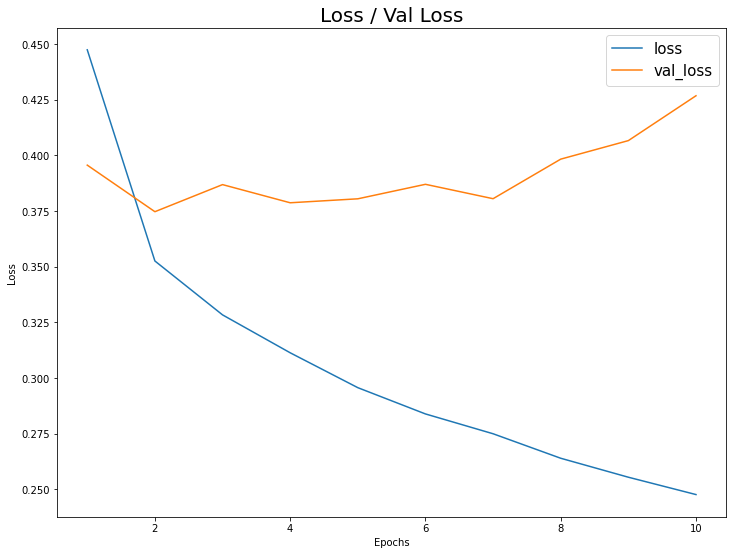

In [42]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

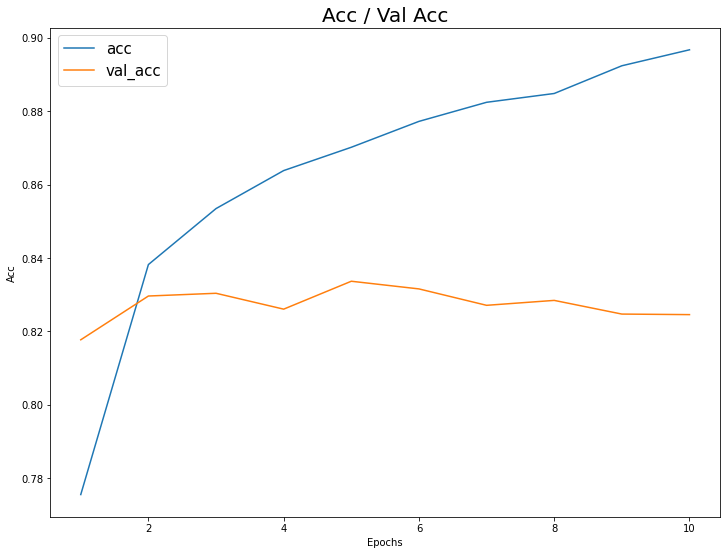

In [43]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()